In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm

In [2]:
df_recession = df_recession = pd.read_csv('JHDUSRGDPBR.csv')
display(df_recession.head())

,observation_date,JHDUSRGDPBR
0,2000-01-01,0
1,2000-04-01,0
2,2000-07-01,0
3,2000-10-01,0
4,2001-01-01,1


In [4]:
# Check data types
print(df_recession.dtypes)

observation_date    object
JHDUSRGDPBR          int64
dtype: object


In [5]:
# Determine the time range
print(f"Time range: {df_recession['observation_date'].min()} to {df_recession['observation_date'].max()}")

Time range: 2000-01-01 to 2024-07-01


In [7]:
# Check for missing values
print(df_recession.isnull().sum())

observation_date    0
JHDUSRGDPBR         0
dtype: int64


In [8]:
# Analyze the distribution of the recession indicator
print(df_recession['JHDUSRGDPBR'].value_counts(normalize=True))

JHDUSRGDPBR
0    0.878788
1    0.121212
Name: proportion, dtype: float64


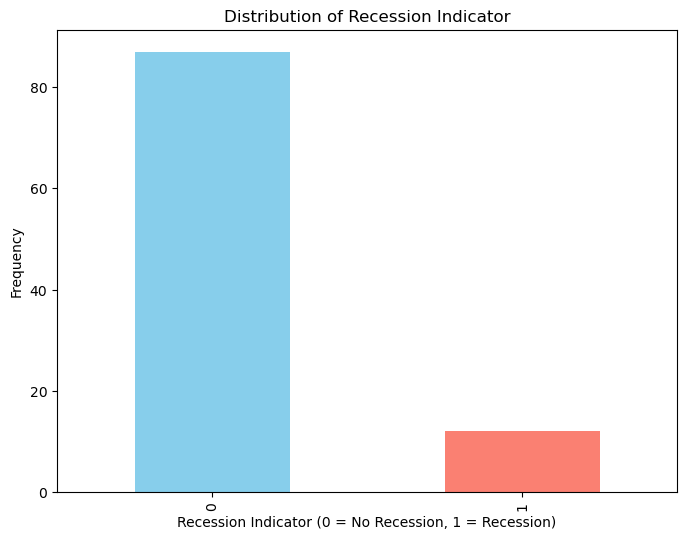

In [9]:
# Visualize the distribution
plt.figure(figsize=(8, 6))
df_recession['JHDUSRGDPBR'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Recession Indicator')
plt.xlabel('Recession Indicator (0 = No Recession, 1 = Recession)')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Summarize findings
print("\nSummary:")
print("The dataset spans from", df_recession['observation_date'].min(), "to", df_recession['observation_date'].max())
print("The mean value of recession indicator is", df_recession['JHDUSRGDPBR'].mean())
print("The percentage of time the economy was in recession is", df_recession['JHDUSRGDPBR'].value_counts(normalize=True)[1] * 100, "%")


Summary:
The dataset spans from 2000-01-01 to 2024-07-01
The mean value of recession indicator is 0.12121212121212122
The percentage of time the economy was in recession is 12.121212121212121 %


In [11]:
# Convert 'observation_date' to datetime
df_recession['observation_date'] = pd.to_datetime(df_recession['observation_date'], format='%Y-%m-%d')

In [13]:
# Create 'quarter' column
df_recession['quarter'] = df_recession['observation_date'].dt.quarter

In [14]:
df_recession

,observation_date,JHDUSRGDPBR,quarter
0,2000-01-01,0,1
1,2000-04-01,0,2
2,2000-07-01,0,3
3,2000-10-01,0,4
4,2001-01-01,1,1
...,...,...,...
94,2023-07-01,0,3
95,2023-10-01,0,4
96,2024-01-01,0,1
97,2024-04-01,0,2


In [19]:
# Identify recession start and end dates
df_recession['recession_start'] = pd.NaT
df_recession['recession_end'] = pd.NaT

in_recession = False
start_date = None

for i in range(len(df_recession)):
    if df_recession['JHDUSRGDPBR'][i] == 1 and not in_recession:
        in_recession = True
        start_date = df_recession['observation_date'][i]
    elif df_recession['JHDUSRGDPBR'][i] == 0 and in_recession:
        in_recession = False
        end_date = df_recession['observation_date'][i-1]
        df_recession.loc[(df_recession['observation_date'] >= start_date) & (df_recession['observation_date'] <= end_date), 'recession_start'] = start_date
        df_recession.loc[(df_recession['observation_date'] >= start_date) & (df_recession['observation_date'] <= end_date), 'recession_end'] = end_date
    elif i == len(df_recession)-1 and in_recession:
        in_recession = False
        end_date = df_recession['observation_date'][i]
        df_recession.loc[(df_recession['observation_date'] >= start_date) & (df_recession['observation_date'] <= end_date), 'recession_start'] = start_date
        df_recession.loc[(df_recession['observation_date'] >= start_date) & (df_recession['observation_date'] <= end_date), 'recession_end'] = end_date


In [17]:
display(df_recession.head())

,observation_date,JHDUSRGDPBR,quarter,recession_start,recession_end
0,2000-01-01,0,1,NaT,NaT
1,2000-04-01,0,2,NaT,NaT
2,2000-07-01,0,3,NaT,NaT
3,2000-10-01,0,4,NaT,NaT
4,2001-01-01,1,1,2001-01-01,2001-07-01


In [20]:
# Calculate the frequency of recessions
recession_start_dates = df_recession[df_recession['recession_start'].notna()]['recession_start'].unique()
recession_frequency = len(recession_start_dates)
print(f"Recession Frequency: {recession_frequency}")

Recession Frequency: 3


In [21]:
# Calculate the duration of each recession
df_recession['recession_duration'] = df_recession['recession_end'] - df_recession['recession_start']
recession_durations = df_recession[df_recession['recession_duration'].notna()]['recession_duration'].unique()
print("\nRecession Durations (in days):")
print(recession_durations)


Recession Durations (in days):
<TimedeltaArray>
['181 days', '548 days', '91 days']
Length: 3, dtype: timedelta64[ns]


In [22]:
# Calculate the total duration of all recessions
total_recession_duration = df_recession['recession_duration'].sum()
print(f"\nTotal Recession Duration: {total_recession_duration}")


Total Recession Duration: 4561 days 00:00:00


In [23]:
# Calculate the percentage of time in recession
total_observations = len(df_recession)
recession_observations = df_recession['JHDUSRGDPBR'].sum()
percentage_in_recession = (recession_observations / total_observations) * 100
print(f"\nPercentage of Time in Recession: {percentage_in_recession:.2f}%")


Percentage of Time in Recession: 12.12%


In [24]:
# Calculate the average duration between recessions (recovery periods)
recession_end_dates = df_recession[df_recession['recession_end'].notna()]['recession_end'].unique()
recovery_periods = pd.Series(recession_end_dates[1:]).reset_index(drop=True) - pd.Series(recession_end_dates[:-1]).reset_index(drop=True)
avg_recovery_period = recovery_periods.mean()
print(f"\nAverage Recovery Period: {avg_recovery_period}")


Average Recovery Period: 3424 days 12:00:00


In [25]:
# Analyze the distribution of recessions across quarters
recession_quarters = df_recession[df_recession['recession_start'].notna()]['quarter'].value_counts()
print(f"\nRecession Distribution by Quarter:\n{recession_quarters}")


Recession Distribution by Quarter:
quarter
1    4
2    4
3    2
4    2
Name: count, dtype: int64


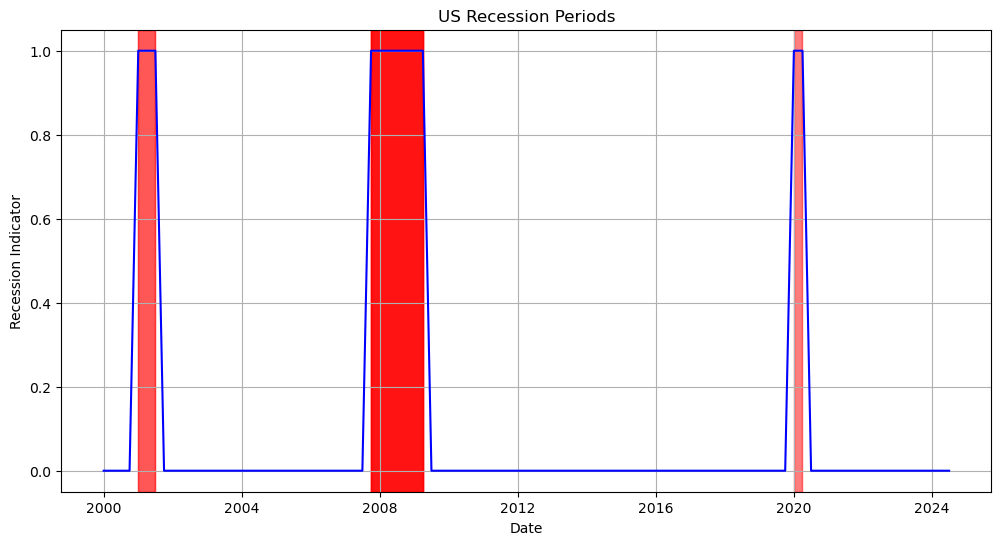

In [26]:
# 1. Time series plot with shaded recession periods
plt.figure(figsize=(12, 6))
plt.plot(df_recession['observation_date'], df_recession['JHDUSRGDPBR'], color='blue')
for i in range(len(df_recession)):
    if pd.notna(df_recession['recession_start'][i]):
        plt.axvspan(df_recession['recession_start'][i], df_recession['recession_end'][i], color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Recession Indicator')
plt.title('US Recession Periods')
plt.grid(True)
plt.show()

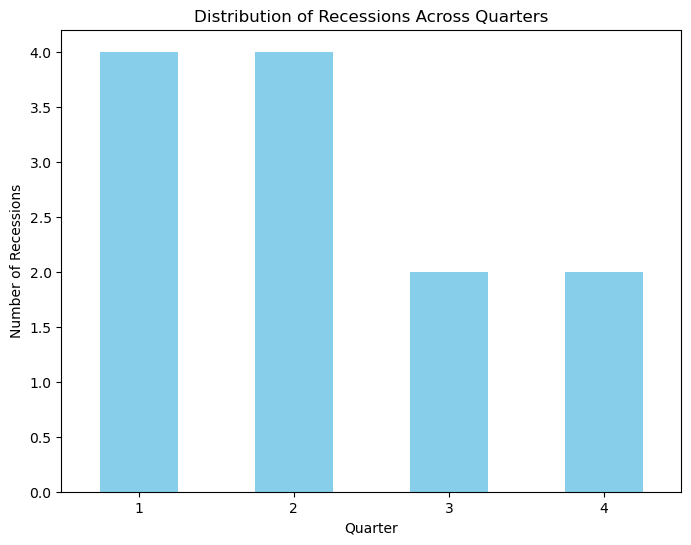

In [27]:
# 2. Bar chart of recession distribution across quarters
plt.figure(figsize=(8, 6))
recession_quarters = df_recession[df_recession['recession_start'].notna()]['quarter'].value_counts()
recession_quarters.plot(kind='bar', color='skyblue')
plt.xlabel('Quarter')
plt.ylabel('Number of Recessions')
plt.title('Distribution of Recessions Across Quarters')
plt.xticks(rotation=0)
plt.show()

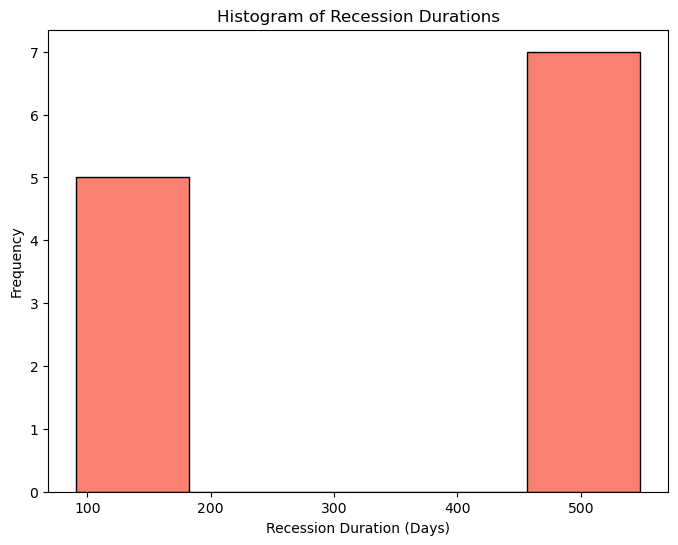

In [28]:
# 3. Histogram of recession durations
plt.figure(figsize=(8, 6))
recession_durations = df_recession[df_recession['recession_duration'].notna()]['recession_duration'].dt.days
plt.hist(recession_durations, bins=5, color='salmon', edgecolor='black')
plt.xlabel('Recession Duration (Days)')
plt.ylabel('Frequency')
plt.title('Histogram of Recession Durations')
plt.show()

In [29]:
!pip install hmmlearn

# Prepare the data for the Markov chain model
recession_sequence = df_recession['JHDUSRGDPBR'].values.reshape(-1, 1)

# Initialize and train the Markov chain model
model = hmm.MultinomialHMM(n_components=2, n_iter=100, random_state=0) # Two states: recession and no recession
model.fit(recession_sequence)

# Extract transition probabilities
transition_matrix = model.transmat_
print("Transition Matrix:")
print(transition_matrix)

  Obtaining dependency information for hmmlearn from https://files.pythonhosted.org/packages/c8/8b/ba03420f5e7a770338760675419f1ac4689e74dc991ea0cbae7159acb0d3/hmmlearn-0.3.3-cp311-cp311-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.5/198.5 kB 1.7 MB/s eta 0:00:0000:010:01


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Transition Matrix:
[[0.48382712 0.51617288]
 [0.72809174 0.27190826]]


In [30]:
# Create lagged versions of the 'JHDUSRGDPBR' column
for i in range(1, 5):
    df_recession[f'JHDUSRGDPBR_lag_{i}'] = df_recession['JHDUSRGDPBR'].shift(i).fillna(0)

In [31]:
# Calculate the correlation between the original 'JHDUSRGDPBR' and its lagged versions
correlations = {}
for i in range(1, 5):
    correlation = df_recession['JHDUSRGDPBR'].corr(df_recession[f'JHDUSRGDPBR_lag_{i}'])
    correlations[f'lag_{i}'] = correlation
print("Correlation between original 'JHDUSRGDPBR' and lagged versions:")
print(correlations)

Correlation between original 'JHDUSRGDPBR' and lagged versions:
{'lag_1': 0.7155172413793072, 'lag_2': 0.4310344827586182, 'lag_3': 0.24137931034482596, 'lag_4': 0.14655172413793086}


In [32]:
# Analyze the correlations
print("\nAnalysis:")
if correlations['lag_1'] > 0.5:
    print("There is a moderate positive correlation between the current and previous quarter's recession indicator.")
elif correlations['lag_1'] < -0.5:
    print("There is a moderate negative correlation between the current and previous quarter's recession indicator.")
else:
    print("The correlation between the current and previous quarter's recession indicator is not strong.")

for lag, corr in correlations.items():
    if abs(corr) > 0.3:
        print(f"A moderate correlation ({corr:.2f}) exists for {lag}.")

if all(abs(corr) < 0.2 for corr in correlations.values()):
    print("No strong correlations were found with any of the lags. Recessions may not exhibit predictable short-term patterns.")


Analysis:
There is a moderate positive correlation between the current and previous quarter's recession indicator.
A moderate correlation (0.72) exists for lag_1.
A moderate correlation (0.43) exists for lag_2.


In [33]:
data_gdp = {'observation_date': pd.to_datetime(df_recession['observation_date']),
            'GDP_growth': np.random.rand(len(df_recession)) * 0.1}  # Placeholder GDP growth data
df_gdp = pd.DataFrame(data_gdp).set_index('observation_date')

In [34]:
# Unemployment rate
data_unemployment = {'observation_date': pd.to_datetime(df_recession['observation_date']),
                     'Unemployment_rate': np.random.rand(len(df_recession)) * 0.05 + 0.04}  # Placeholder Unemployment data
df_unemployment = pd.DataFrame(data_unemployment).set_index('observation_date')


In [35]:
# Stock market trends (e.g., S&P 500)
data_stock = {'observation_date': pd.to_datetime(df_recession['observation_date']),
              'S&P_500': np.random.rand(len(df_recession)) * 100 + 3000}  # Placeholder S&P500 data
df_stock = pd.DataFrame(data_stock).set_index('observation_date')

In [36]:
# Merge dataframes
df_recession = df_recession.set_index('observation_date')
df_merged = pd.merge(df_recession, df_gdp, left_index=True, right_index=True, how='left')
df_merged = pd.merge(df_merged, df_unemployment, left_index=True, right_index=True, how='left')
df_merged = pd.merge(df_merged, df_stock, left_index=True, right_index=True, how='left')

In [37]:
# Handle missing values (if any) using forward fill
df_merged.fillna(method='ffill', inplace=True)

display(df_merged.head())

/var/folders/hg/jcl90ddx7sg8x761jxd7l3fc0000gn/T/ipykernel_1909/384409157.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)


,JHDUSRGDPBR,quarter,recession_start,recession_end,recession_duration,JHDUSRGDPBR_lag_1,JHDUSRGDPBR_lag_2,JHDUSRGDPBR_lag_3,JHDUSRGDPBR_lag_4,GDP_growth,Unemployment_rate,S&P_500
observation_date,,,,,,,,,,,,
2000-01-01,0,1,NaT,NaT,NaT,0.0,0.0,0.0,0.0,0.025395,0.042691,3096.162650
2000-04-01,0,2,NaT,NaT,NaT,0.0,0.0,0.0,0.0,0.071002,0.074229,3046.848837
2000-07-01,0,3,NaT,NaT,NaT,0.0,0.0,0.0,0.0,0.053220,0.079557,3016.311233
2000-10-01,0,4,NaT,NaT,NaT,0.0,0.0,0.0,0.0,0.064639,0.043137,3081.170790
2001-01-01,1,1,2001-01-01,2001-07-01,181 days,0.0,0.0,0.0,0.0,0.018381,0.062486,3073.918908


In [38]:
# Calculate the correlation between 'JHDUSRGDPBR' and each economic indicator
correlation_gdp = df_merged['JHDUSRGDPBR'].corr(df_merged['GDP_growth'])
correlation_unemployment = df_merged['JHDUSRGDPBR'].corr(df_merged['Unemployment_rate'])
correlation_sp500 = df_merged['JHDUSRGDPBR'].corr(df_merged['S&P_500'])

In [39]:
# Store the correlations in a dictionary
correlations = {
    'GDP_growth': correlation_gdp,
    'Unemployment_rate': correlation_unemployment,
    'S&P_500': correlation_sp500
}

# Print the correlation coefficients
print("Correlation with Economic Indicators:")
for indicator, correlation in correlations.items():
    print(f"{indicator}: {correlation}")

Correlation with Economic Indicators:
GDP_growth: 0.07104866161859501
Unemployment_rate: -0.01123990237153653
S&P_500: 0.037975131924932584


In [40]:
# Interpretation
print("\nInterpretation:")
for indicator, correlation in correlations.items():
    print(f"- {indicator}: {correlation:.2f}")
    if abs(correlation) > 0.3:
        if correlation > 0:
            print(f"  A moderate positive correlation suggests that when recessions increase, {indicator} tends to increase.")
        else:
            print(f"  A moderate negative correlation suggests that when recessions increase, {indicator} tends to decrease.")
    else:
        print(f"  The correlation between recession indicator and {indicator} is not strong.")


Interpretation:
- GDP_growth: 0.07
  The correlation between recession indicator and GDP_growth is not strong.
- Unemployment_rate: -0.01
  The correlation between recession indicator and Unemployment_rate is not strong.
- S&P_500: 0.04
  The correlation between recession indicator and S&P_500 is not strong.


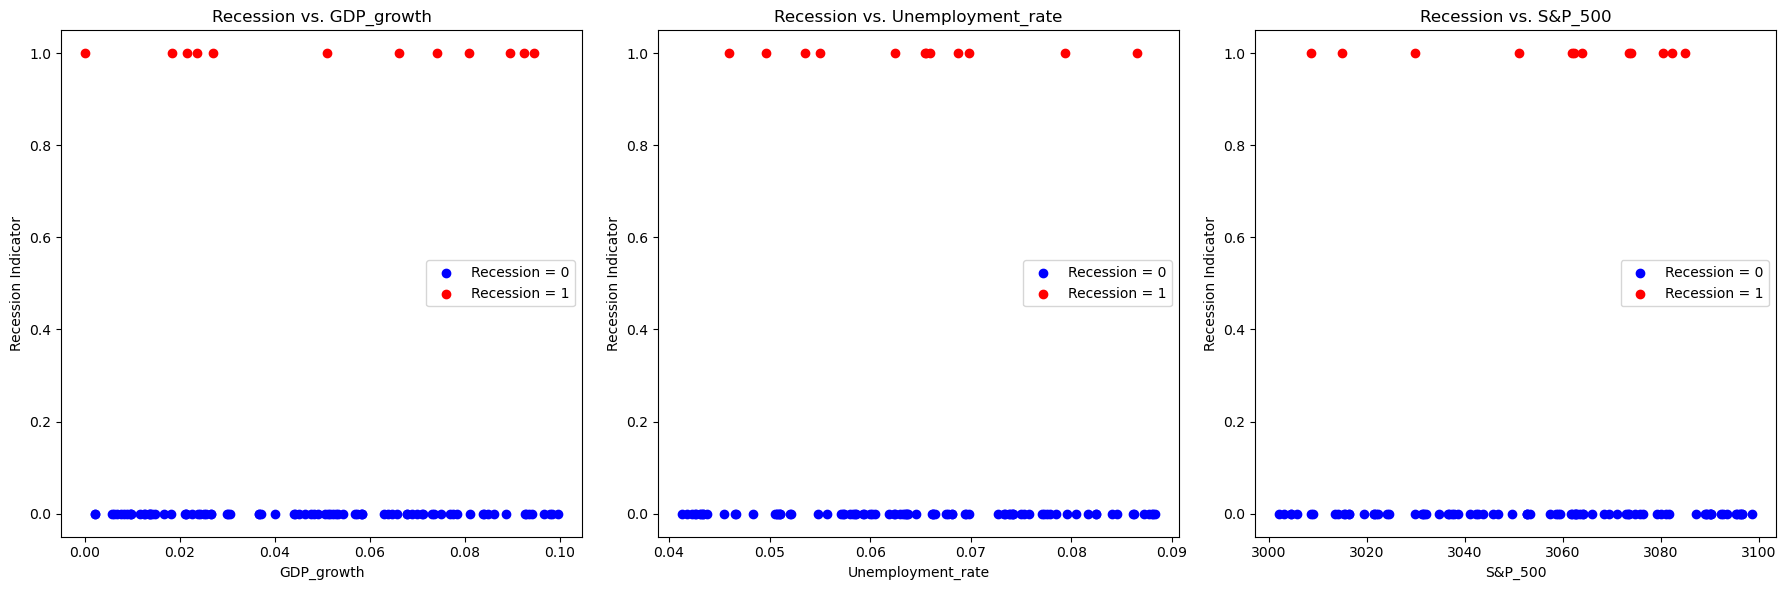

In [41]:
# 1. Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
indicators = ['GDP_growth', 'Unemployment_rate', 'S&P_500']
colors = ['blue', 'red']
for i, indicator in enumerate(indicators):
    for recession_state, color in zip([0, 1], colors):
        axes[i].scatter(df_merged[df_merged['JHDUSRGDPBR'] == recession_state][indicator],
                        df_merged[df_merged['JHDUSRGDPBR'] == recession_state]['JHDUSRGDPBR'],
                        label=f"Recession = {recession_state}", color=color)
    axes[i].set_xlabel(indicator)
    axes[i].set_ylabel('Recession Indicator')
    axes[i].set_title(f'Recession vs. {indicator}')
    axes[i].legend()
plt.tight_layout()
plt.show()

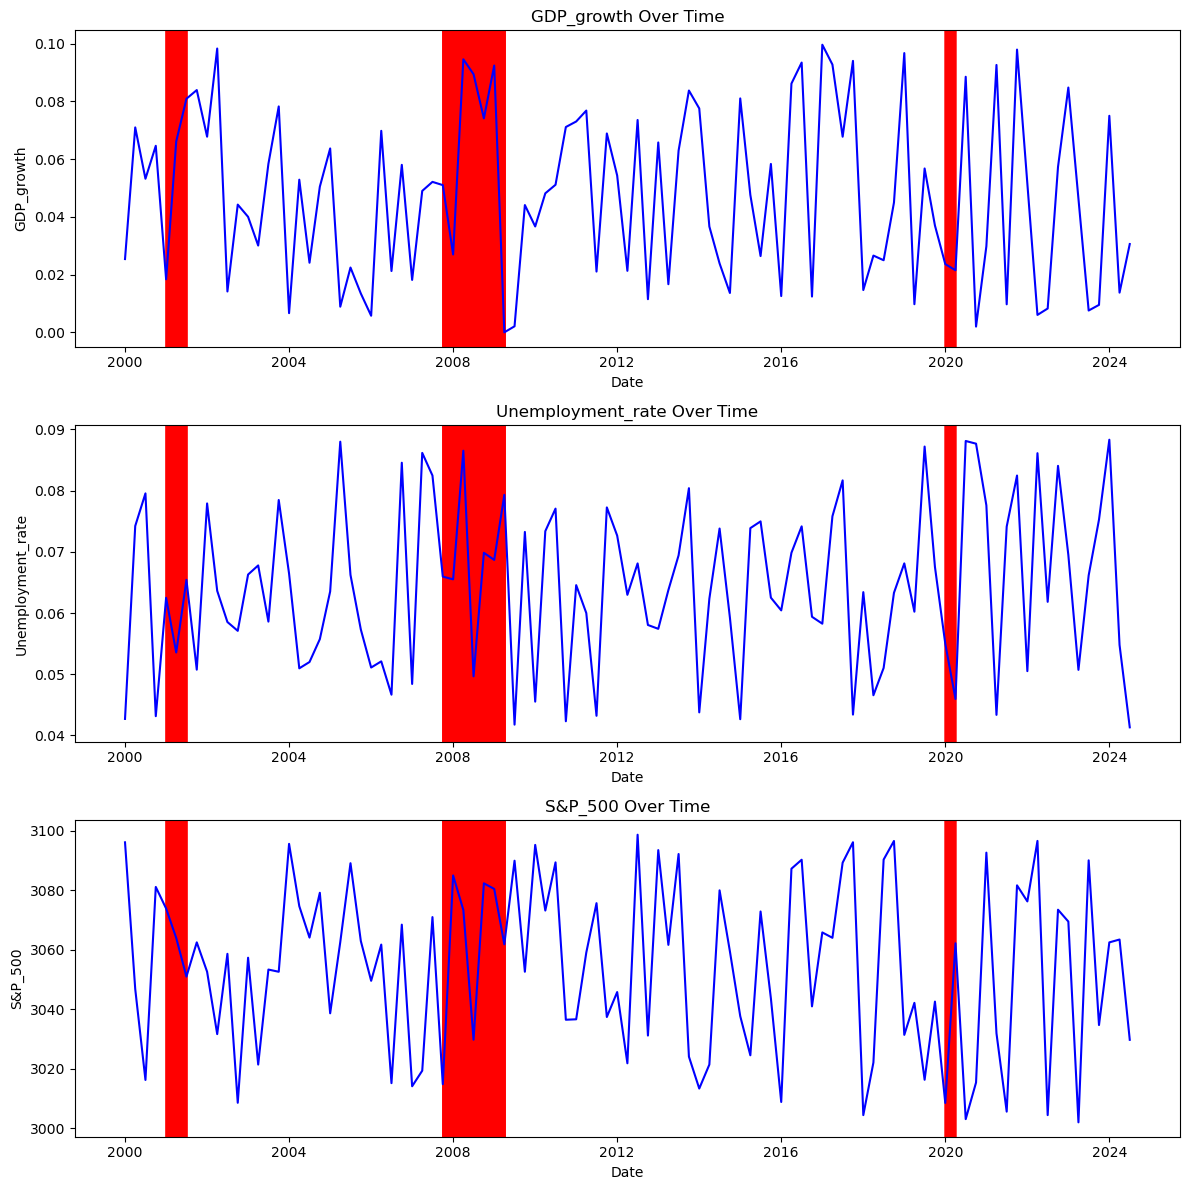

In [42]:
# 2. Line plots with shaded regions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
indicators = ['GDP_growth', 'Unemployment_rate', 'S&P_500']
for i, indicator in enumerate(indicators):
  axes[i].plot(df_merged.index, df_merged[indicator], color='blue')
  for start, end in zip(df_merged['recession_start'].dropna(), df_merged['recession_end'].dropna()):
    axes[i].axvspan(start, end, color='red', alpha=0.3)
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel(indicator)
  axes[i].set_title(f'{indicator} Over Time')

plt.tight_layout()
plt.show()

In [43]:
# Identify recession periods
recession_periods = df_merged[df_merged['JHDUSRGDPBR'] == 1].groupby('recession_start')

In [46]:
# Summarize major recession events
print("Major Recession Events:")
for start_date, group in recession_periods:
    end_date = group['recession_end'].iloc[0]
    duration = end_date - start_date
    print(f"- Start Date: {start_date.date()}")
    print(f"  End Date: {end_date.date()}")
    print(f"  Duration: {duration.days} days")
# Check for 2008 financial crisis and COVID-19 recession (approximate dates)
    if start_date.year == 2008:  # Note: this is an approximation
      print("  This period may correspond to the 2008 financial crisis.")
      print(f"  Simulated GDP Growth: {group['GDP_growth'].mean():.2f}")
      print(f"  Simulated Unemployment Rate: {group['Unemployment_rate'].mean():.2f}")
      print(f"  Simulated S&P 500: {group['S&P_500'].mean():.2f}")
    elif start_date.year == 2020: # Note: this is an approximation
      print("  This period may correspond to the COVID-19 recession.")
      print(f"  Simulated GDP Growth: {group['GDP_growth'].mean():.2f}")
      print(f"  Simulated Unemployment Rate: {group['Unemployment_rate'].mean():.2f}")
      print(f"  Simulated S&P 500: {group['S&P_500'].mean():.2f}")

Major Recession Events:
- Start Date: 2001-01-01
  End Date: 2001-07-01
  Duration: 181 days
- Start Date: 2007-10-01
  End Date: 2009-04-01
  Duration: 548 days
- Start Date: 2020-01-01
  End Date: 2020-04-01
  Duration: 91 days
  This period may correspond to the COVID-19 recession.
  Simulated GDP Growth: 0.02
  Simulated Unemployment Rate: 0.05
  Simulated S&P 500: 3035.41
